# HW2Q7 a,b
### import library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

### constants

In [2]:
EPSILON = 0.01
MAX_ITER = 1000000
RHO = 0.01

### functions

In [3]:
def phi_func(row, n_degree):
    """
    This is the phi function that apply to each row
    """
    if n_degree == -1:
        return row
    else:
        result = np.array([])
        for i in row:
            for j in range(1, n_degree + 1):
                result = np.concatenate([result, [np.power(i, j)]])
        return np.concatenate([result, [1]])


def feature_normalization(trn, tst, val):
    """
    This function normalize all training, testing and validation sets.
    It normalize the testing and validation sets with parameter computed from training set.
    """
    for i in range(0, len(trn[0]) - 1):
        avg, max_minus_min = normalize_helper(trn[:, [i]]) 
        trn[:, [i]] = (trn[:, [i]] - avg) / max_minus_min
        tst[:, [i]] = (tst[:, [i]] - avg) / max_minus_min
        val[:, [i]] = (val[:, [i]] - avg) / max_minus_min
    return trn, tst, val


def normalize_helper(colum):
    """
    calculates the mean and range
    """
    avg = np.mean(colum)
    max_minus_min = np.max(colum) - np.min(colum)
    return avg, max_minus_min


def linear_reg(data, s, n_degree=-1, gd_rho=RHO):
    """
    The main function of linear regression
    input s = 1 to do gradient descent and s = 0 to do closed form
    """
    data_copy = data.copy()
    for key in ['X_trn', 'X_tst', 'X_val']:
        data_copy[key] = np.apply_along_axis(phi_func, 1, data_copy[key], n_degree)
    # feature normalization:
    x_trn = data_copy['X_trn']
    x_tst = data_copy['X_tst']
    x_val = data_copy['X_val']
    x_trn, x_tst, x_val = feature_normalization(x_trn, x_tst, x_val)
    data_copy['X_trn'] = x_trn
    data_copy['X_tst'] = x_tst
    data_copy['X_val'] = x_val
    # start regression:
    if s == 0:
        return (data_copy,) + closed_form_reg(data_copy)
    elif s == 1:
        return (data_copy,) + gradient_descent_reg(data_copy, rho=gd_rho)


def closed_form_reg(data):
    """
    wrapper of closed form regression.
    Calculate the learning result, then calculate the errors
    """
    theta_star = closed_form_theta(data)
    err_trn, err_tst, err_val = calc_error(data, theta_star)
    return theta_star, err_trn, err_tst, err_val


def closed_form_theta(data):
    """
    calculate optimal theta from training data
    """
    x_trn = data['X_trn']
    y_trn = data['Y_trn']
    inv = np.linalg.inv(np.matmul(x_trn.transpose(), x_trn))
    theta_star_mat = np.matmul(inv, np.matmul(x_trn.transpose(), y_trn))
    return theta_star_mat


def calc_error(data, theta):
    """
    Calculating errors of training, testing and validation sets
    """
    x_train = data['X_trn']
    x_test = data['X_tst']
    x_val = data['X_val']
    y_train = data['Y_trn']
    y_test = data['Y_tst']
    y_val = data['Y_val']
    err_train = calc_error_xytheta(x_train, y_train, theta)
    err_test = calc_error_xytheta(x_test, y_test, theta)
    err_val = calc_error_xytheta(x_val, y_val, theta)
    return err_train, err_test, err_val


def calc_error_xytheta(x_mat, y_mat, theta_mat):
    """
    A helper that calculates the errors given PHI(X), Y and optimal theta
    """
    err_mat = np.subtract(y_mat, np.matmul(theta_mat.transpose(), x_mat.transpose()).transpose())
    err = np.power(np.linalg.norm(err_mat), 2) / len(err_mat)
    return err


def gradient_descent_reg(data, max_iter=MAX_ITER, rho=RHO, epsilon=EPSILON):
    """
    The main function that does the gradient descent.
    """
    x_train = data['X_trn']
    y_train = data['Y_trn']
    curr_theta = np.full((len(x_train[0]), 1), 0)
    i = 1
    for i in range(0, max_iter):
        new_theta, new_dir = single_descent(curr_theta, rho, x_train, y_train)
        curr_theta = new_theta
        if np.linalg.norm(new_dir) < epsilon:
            print("The total number of iterations is: {} with rho = {}".format(i + 1, rho))
            break
    if i >= max_iter - 1:
        print("Exceeds max iteration: {}; with learning rate: {}".format(max_iter, rho))
    err_trn, err_tst, err_val = calc_error(data, curr_theta)
    return curr_theta, err_trn, err_tst, err_val


def single_descent(curr_theta, rho, x, y):
    """
    compute a single descent with training data
    """
    xt_x = np.matmul(x.transpose(), x)
    xt_y = np.matmul(x.transpose(), y)
    new_dir = (np.matmul(xt_x, curr_theta) - xt_y)
    theta = curr_theta - new_dir * rho
    return theta, new_dir


def plot_regression(data, theta, title=""):
    """
    Plots the regression result
    """
    # plot given data points
    x = data['x']
    y = data['y']
    x_first_col = x[:, [0]]
    plt.scatter(x_first_col, y)
    # plot given regression result theta
    theta_x = np.linspace(-1, 1)
    expanded_x = np.apply_along_axis(phi_func, 1, np.vstack(theta_x), len(theta) - 1)
    # normalizing linspace
    for i in range(0, expanded_x.shape[1] - 1):
        avg, max_minus_min = normalize_helper(expanded_x[:, [i]])
        expanded_x[:, [i]] = (expanded_x[:, [i]] - avg) / max_minus_min
    theta_y = np.matmul(expanded_x, theta)
    plt.plot(list(expanded_x[:, [0]]), list(theta_y))
    plt.title(title + " n = {}".format(theta.shape[0] - 1))
    plt.show()

### calculating the optimal theta from n = 1 to n = 9

Here, I am normalizing my features before I do the training part.

In each training, I first apply phi-function to each row where I generate [x^1, x^2, ... ,x^n 1]

Then I apply the feature normalization, x_i' = (x_i - mean(x_i))/(max(x_i) - min(x_i))

This is a first generate powers then normalization method where I was told to do in class. 

When I am drawing according to theta, I sample from -1 to 1 which gives me some vector like [-1, -0.98, -0/96, ... , 0.98, 1]^T
Then I apply the phi-function to each row which gives me back something like A =:

| -1  | (-1)^2| (-1)^3  |  ... | (-1)^n | 1 |
|---|---|---|---|---|---|
| -0.98  | (-0.98)^2| (-0.98)^3  |  ... | (-0.98)^n | 1 |
| ...  | ...  | ...  | ...  | ...  | ... |
| -0.98  | (-0.98)^2| (-0.98)^3  |  ... | (-0.98)^n | 1 |
| 1  | (1)^2| (1)^3  |  ... | (1)^n | 1 |

Then I normalize the data and then apply this matrix to theta (A theta) which gives back me y's value and then I plot it.

n = 1
closed form calculation:
theta transpose = 
 [[-4.11006944 -0.69675023]]
training error: 1.4305736953400872
testing error: 1.4514033919440033
validation error: 1.7176746552258777


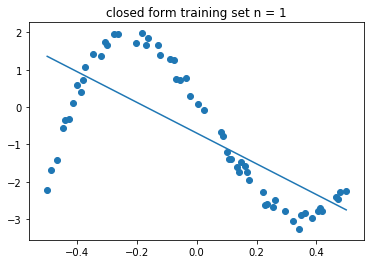

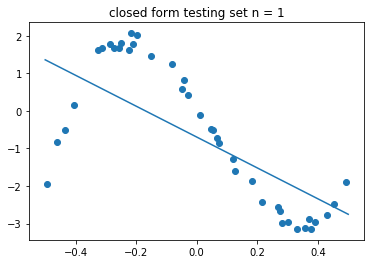

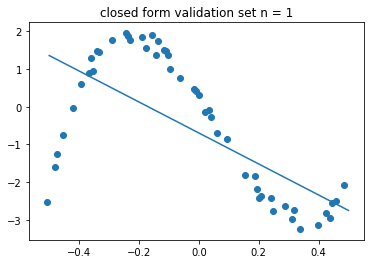

gradient descent calculation:
The total number of iterations is: 140 with rho = 0.01
theta transpose = 
 [[-4.10834483 -0.69675023]]
training error: 1.43057396317176
testing error: 1.4516595081929249
validation error: 1.717741247295772


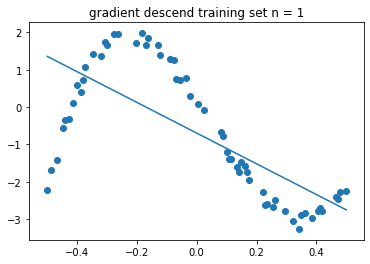

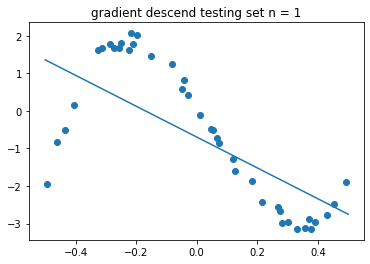

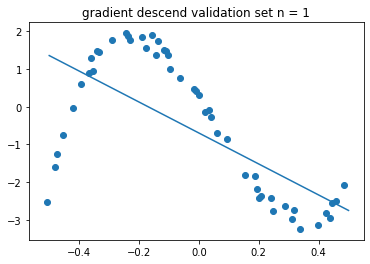

n = 2
closed form calculation:
theta transpose = 
 [[-4.1925242  -2.20600902 -0.69675023]]
training error: 0.9647870552848656
testing error: 0.9601115714572043
validation error: 1.0022413445387783


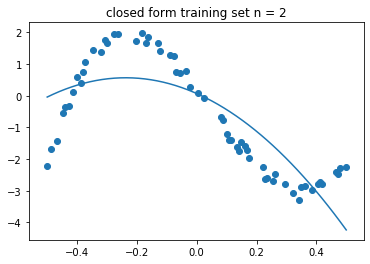

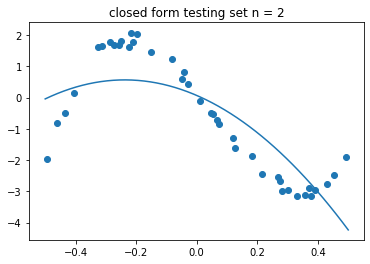

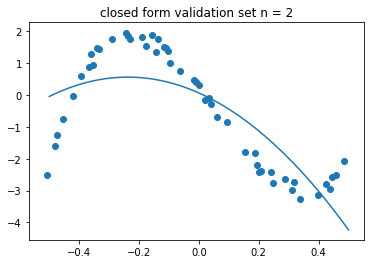

gradient descent calculation:
The total number of iterations is: 145 with rho = 0.01
theta transpose = 
 [[-4.1909664  -2.20524852 -0.69675023]]
training error: 0.9647873212671053
testing error: 0.960295414319094
validation error: 1.0023815014071331


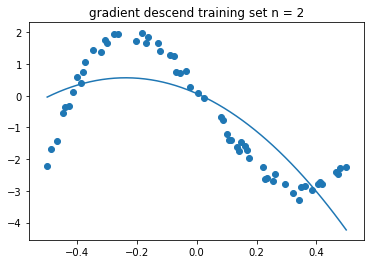

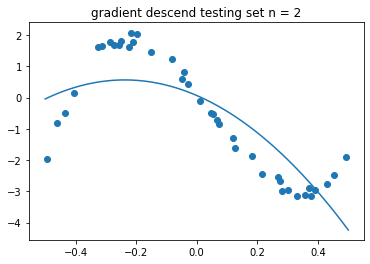

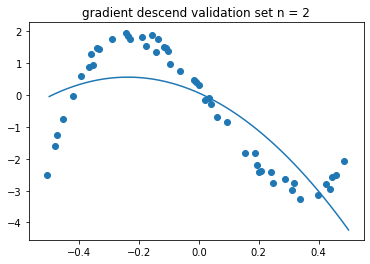

n = 3
closed form calculation:
theta transpose = 
 [[-12.0118246   -2.49457471  12.32622505  -0.69675023]]
training error: 0.02139398288216856
testing error: 0.02078335737430865
validation error: 0.020195780939618296


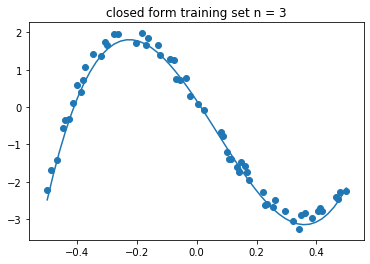

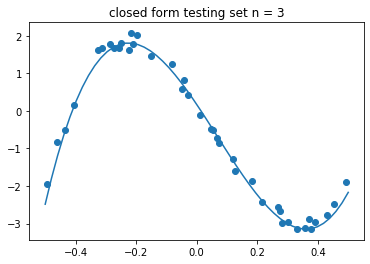

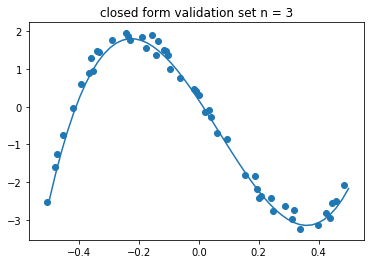

gradient descent calculation:
The total number of iterations is: 2328 with rho = 0.01
theta transpose = 
 [[-11.99072561  -2.49376086  12.29458023  -0.69675023]]
training error: 0.021400295253826154
testing error: 0.020778088198164717
validation error: 0.02020083641945128


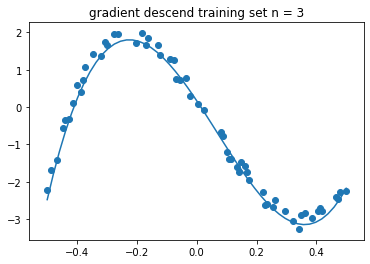

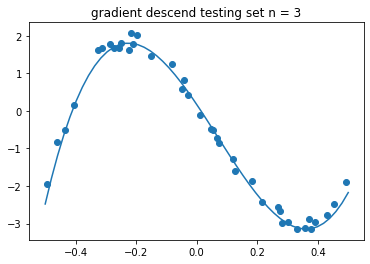

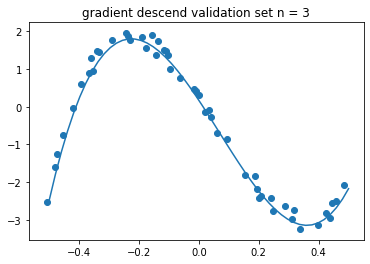

n = 4
closed form calculation:
theta transpose = 
 [[-12.02304688  -2.1600634   12.35342272  -0.3820661   -0.69675023]]
training error: 0.020495535585818417
testing error: 0.022224999131200997
validation error: 0.02147663076681822


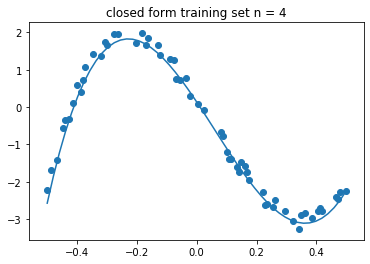

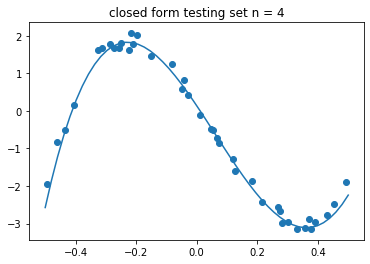

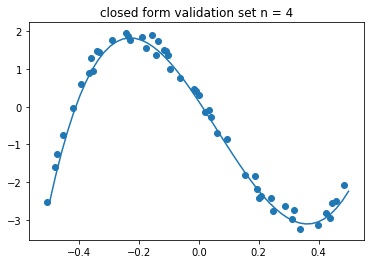

gradient descent calculation:
The total number of iterations is: 2340 with rho = 0.01
theta transpose = 
 [[-12.00210287  -2.16725336  12.32175536  -0.37321399  -0.69675023]]
training error: 0.020502092150886483
testing error: 0.022162890583906865
validation error: 0.02141261141565338


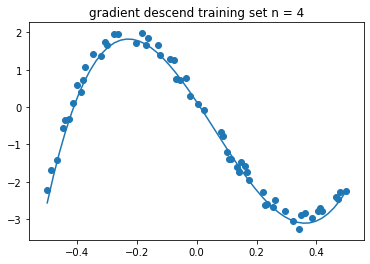

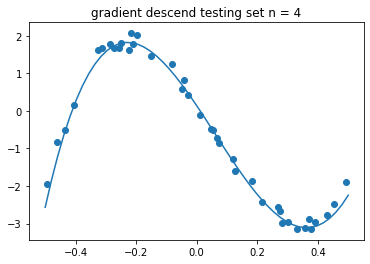

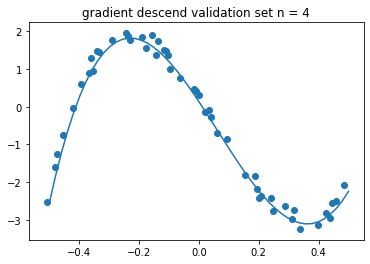

n = 5
closed form calculation:
theta transpose = 
 [[-12.42761559  -2.17192574  14.16012522  -0.36371335  -1.57192203
   -0.69675023]]
training error: 0.019345448917303516
testing error: 0.02397737795128075
validation error: 0.02293132548211088


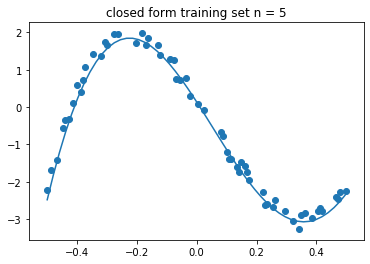

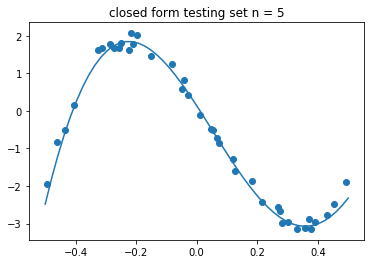

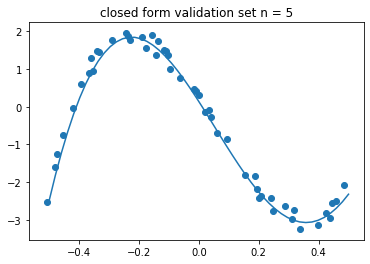

gradient descent calculation:
The total number of iterations is: 24199 with rho = 0.01
theta transpose = 
 [[-12.27012753  -2.16836171  13.50108195  -0.36883005  -1.01886727
   -0.69675023]]
training error: 0.01949120337457743
testing error: 0.02313105821607144
validation error: 0.022153372556433456


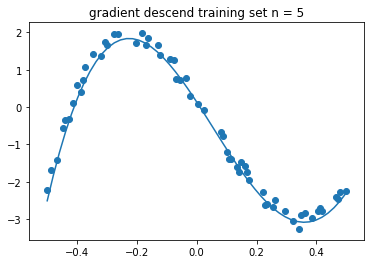

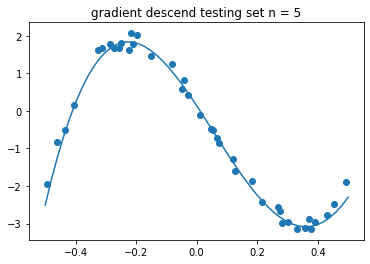

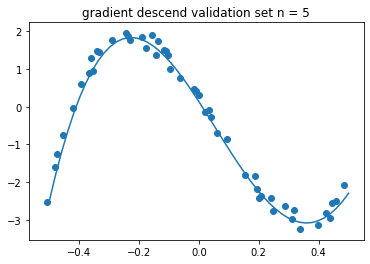

n = 6
closed form calculation:
theta transpose = 
 [[-12.42097356  -2.2832663   14.13847438  -0.04695889  -1.55280331
   -0.2235534   -0.69675023]]
training error: 0.01932643650789503
testing error: 0.02408124045488488
validation error: 0.022865480049231675


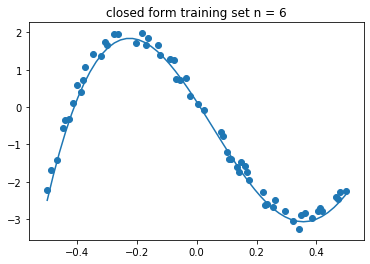

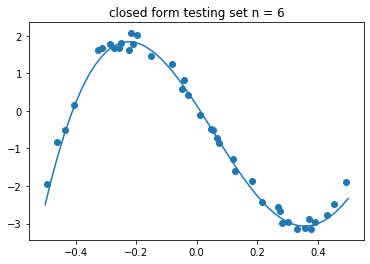

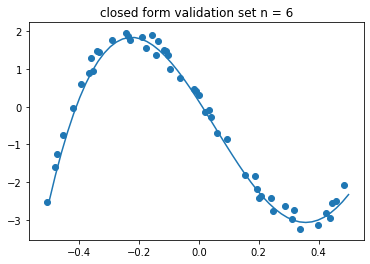

gradient descent calculation:
The total number of iterations is: 24169 with rho = 0.01
theta transpose = 
 [[-12.26085923  -2.32807647  13.47111078   0.08334515  -0.99244927
   -0.31811716  -0.69675023]]
training error: 0.01947521367705189
testing error: 0.023300698778031072
validation error: 0.022094287323246937


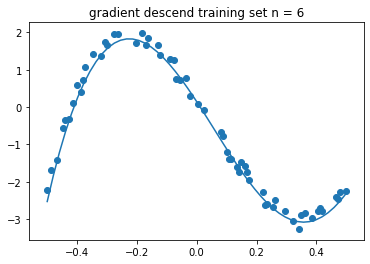

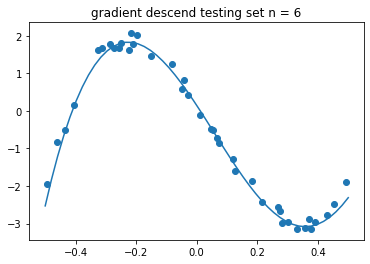

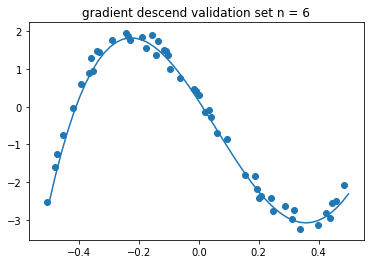

n = 7
closed form calculation:
theta transpose = 
 [[-12.17738732  -2.29062007  11.90410324  -0.03020756   3.27265247
   -0.22645643  -2.90920568  -0.69675023]]
training error: 0.019091429062546843
testing error: 0.024610785135257766
validation error: 0.02357587837112634


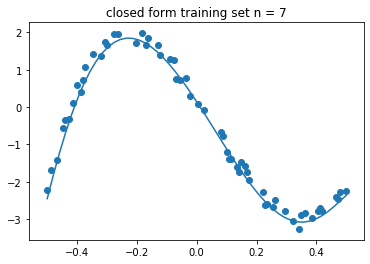

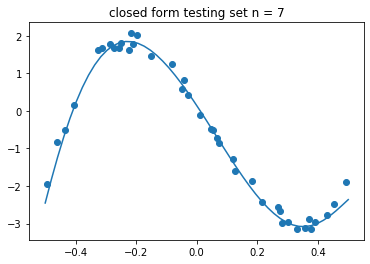

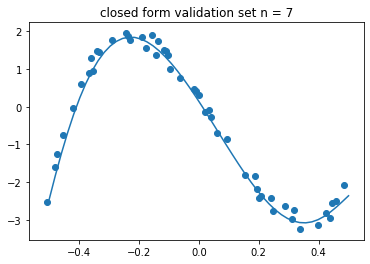

gradient descent calculation:
The total number of iterations is: 12311 with rho = 0.01
theta transpose = 
 [[-12.04857497  -2.28363889  11.26249813  -0.04505422   4.09507573
   -0.21804493  -3.19779254  -0.69675023]]
training error: 0.019152867705897234
testing error: 0.024114932115857725
validation error: 0.023158325682723593


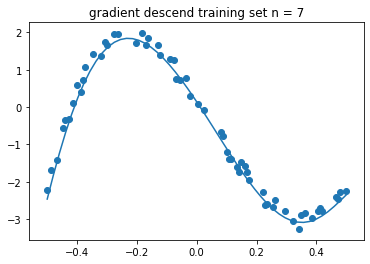

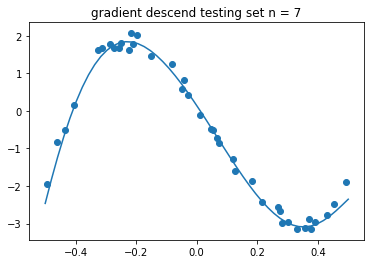

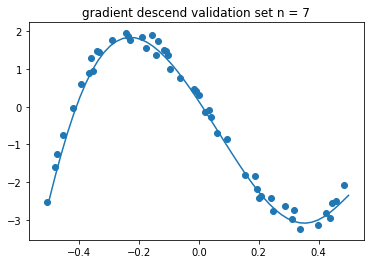

n = 8
closed form calculation:
theta transpose = 
 [[-12.20456733  -1.86358312  12.04031447  -2.2850873    3.04606507
    3.5862409   -2.78168948  -2.00290529  -0.69675023]]
training error: 0.018996390501455872
testing error: 0.024677641205987977
validation error: 0.023989476010813963


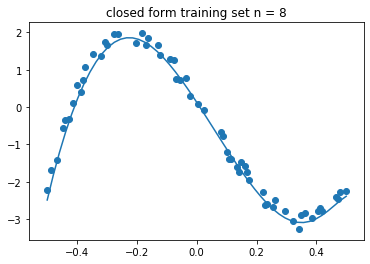

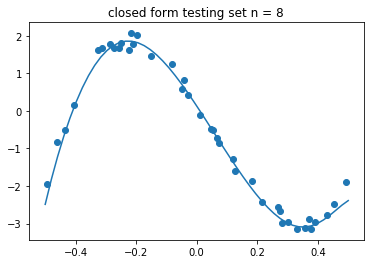

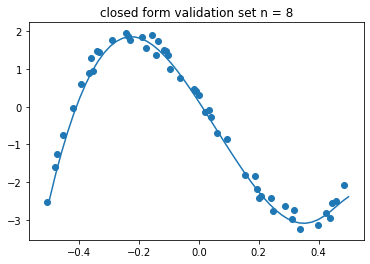

gradient descent calculation:
The total number of iterations is: 12350 with rho = 0.01
theta transpose = 
 [[-12.04733991  -2.30811193  11.25947397  -0.10900127   4.09567685
    0.09846722  -3.19351871  -0.24124799  -0.69675023]]
training error: 0.01913758306805173
testing error: 0.024181471341246253
validation error: 0.02316236868937758


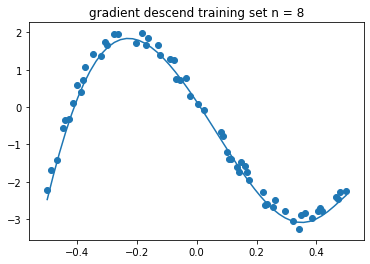

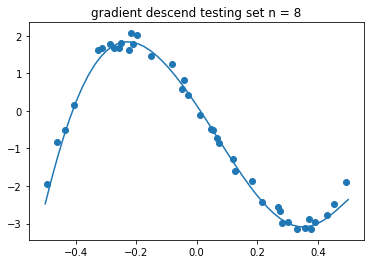

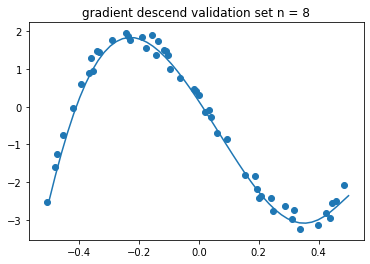

n = 9
closed form calculation:
theta transpose = 
 [[-12.5009194   -1.93136485  16.51505225  -1.91522904 -14.13660597
    2.93895004  21.26208412  -1.64605488 -11.11027787  -0.69675023]]
training error: 0.01877385848809894
testing error: 0.02349219242170969
validation error: 0.024297375512575124


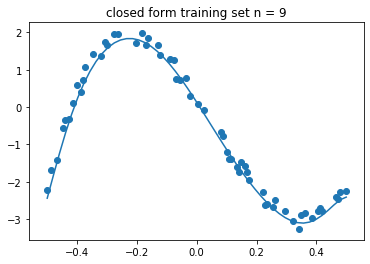

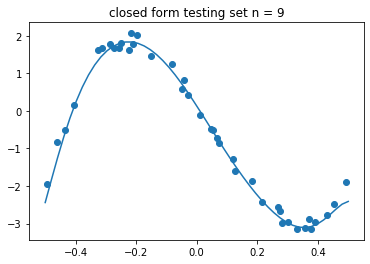

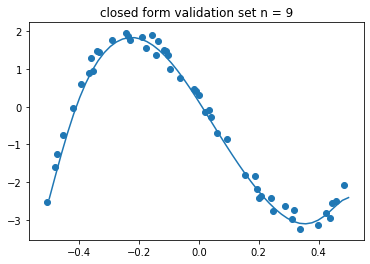

gradient descent calculation:
The total number of iterations is: 8399 with rho = 0.01
theta transpose = 
 [[-11.79954095  -2.29083018   9.64011766  -0.13124509   5.19740668
    0.0661843    0.28269442  -0.18844569  -3.31265884  -0.69675023]]
training error: 0.019495978871028226
testing error: 0.024959801748284653
validation error: 0.024853252706403723


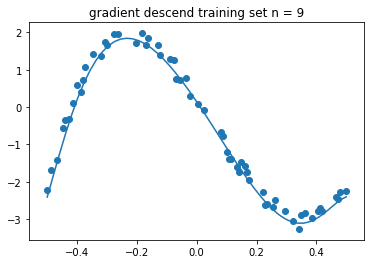

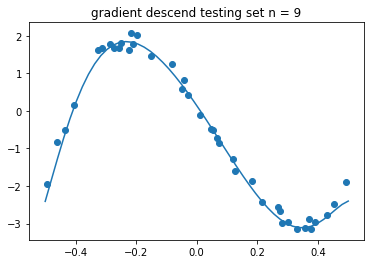

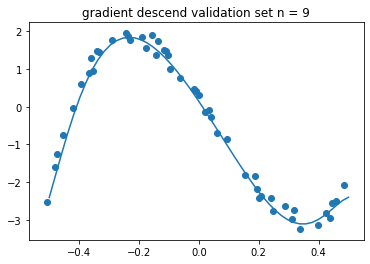

In [4]:
d1 = sio.loadmat('./data/dataset_hw2.mat')
d1.pop('__header__')
d1.pop('__version__')
d1.pop('__globals__')
closed_trn_err_list = []
closed_tst_err_list = []
closed_val_err_list = []
gd_trn_err_list = []
gd_tst_err_list = []
gd_val_err_list = []
for n in range(1, 10):
    print('n = {}'.format(n))
    # closed form:
    print("closed form calculation:")
    data_copy, theta_star, err_trn, err_tst, err_val = linear_reg(d1, 0, n_degree=n)
    closed_trn_err_list.append(err_trn)
    closed_tst_err_list.append(err_tst)
    closed_val_err_list.append(err_val)
    print("theta transpose = \n {}".format(theta_star.transpose()))
    print("training error: {}".format(err_trn))
    print("testing error: {}".format(err_tst))
    print("validation error: {}".format(err_val))
    plot_regression({"x": data_copy['X_trn'], "y": data_copy["Y_trn"]}, theta_star, title="closed form training set")
    plot_regression({"x": data_copy['X_tst'], "y": data_copy["Y_tst"]}, theta_star, title="closed form testing set")
    plot_regression({"x": data_copy['X_val'], "y": data_copy["Y_val"]}, theta_star, title="closed form validation set")
    
    # gradient descents:
    print("gradient descent calculation:")
    data_copy, theta_star, err_trn, err_tst, err_val = linear_reg(d1, 1, n_degree=n)
    gd_trn_err_list.append(err_trn)
    gd_tst_err_list.append(err_tst)
    gd_val_err_list.append(err_val)
    print("theta transpose = \n {}".format(theta_star.transpose()))
    print("training error: {}".format(err_trn))
    print("testing error: {}".format(err_tst))
    print("validation error: {}".format(err_val))
    plot_regression({"x": data_copy['X_trn'], "y": data_copy["Y_trn"]}, theta_star, title="gradient descend training set")
    plot_regression({"x": data_copy['X_tst'], "y": data_copy["Y_tst"]}, theta_star, title="gradient descend testing set")
    plot_regression({"x": data_copy['X_val'], "y": data_copy["Y_val"]}, theta_star, title="gradient descend validation set")

### errors change as a function of n

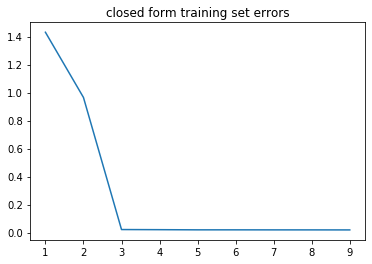

In [5]:
plt.plot(np.arange(1, len(closed_trn_err_list) + 1, 1), closed_trn_err_list)
plt.title("closed form training set errors")
plt.show()

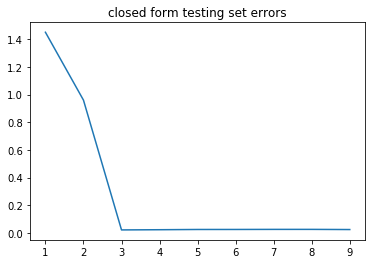

In [6]:
plt.plot(np.arange(1, len(closed_tst_err_list) + 1, 1), closed_tst_err_list)
plt.title("closed form testing set errors")
plt.show()

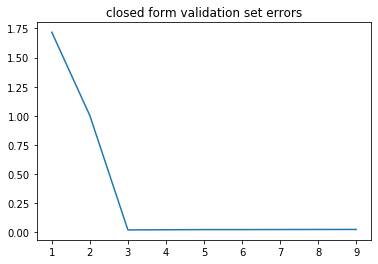

In [7]:
plt.plot(np.arange(1, len(closed_val_err_list) + 1, 1), closed_val_err_list)
plt.title("closed form validation set errors")
plt.show()

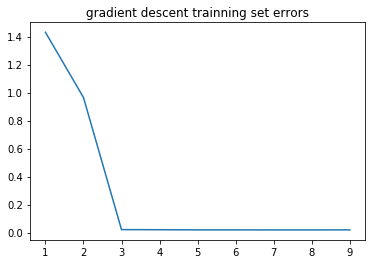

In [8]:
plt.plot(np.arange(1, len(gd_trn_err_list) + 1, 1), gd_trn_err_list)
plt.title("gradient descent trainning set errors")
plt.show()

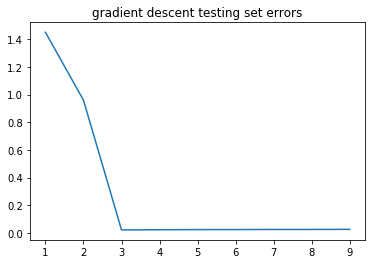

In [9]:
plt.plot(np.arange(1, len(gd_tst_err_list) + 1, 1), gd_tst_err_list)
plt.title("gradient descent testing set errors")
plt.show()

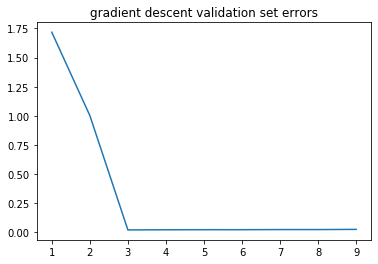

In [10]:
plt.plot(np.arange(1, len(gd_val_err_list) + 1, 1), gd_val_err_list)
plt.title("gradient descent validation set errors")
plt.show()

### problem c is on another notebook: q7c.ipynb